## imports

In [1]:
from IPython.display import clear_output
!pip install hazm
clear_output()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter
from hazm import *
# from hazm import Normalizer, stopwords_list, word_tokenize
from transformers import AutoConfig, AutoTokenizer, AutoModel, TFAutoModel, logging
import tensorflow as tf
import numpy as np
import seaborn as sns
import gc
from sklearn.decomposition import PCA

from keras.optimizers import Adam, SGD
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from tensorflow.keras.layers import Input, Reshape, Conv1D, MaxPooling1D, Flatten, Dense, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.backend import clear_session

In [3]:
# logging.set_verbosity_error()

## Device Config

In [4]:
device = "/gpu:0" if tf.config.list_physical_devices("GPU") else "/cpu:0"

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

device

'/gpu:0'

## Dataset

In [5]:
df = pd.read_csv('../input/persian-spam-email/emails.csv')
df.head()

,text,label
0,﻿ممنون آقا سامان.\nمن پارسال اصلا آزاد شرکت نک...,ham
1,﻿سلام آقای کریمی\nبالاخره آزمونارشد تموم شد من...,ham
2,﻿درود بر حاج وحیدی بنده بعنوان یک دکتری تاریخ ...,ham
3,﻿با سلام و احترام\nضمن تقدیر از مسولین محترم ...,ham
4,﻿با سلام اینجانب یک دستگاه خودرو پراید 131 با ...,ham


In [6]:
df.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham     500    500  ﻿مدتی است که همراه اول با پیامک  مشتریان خود ر...    1
spam    500    500  ﻿\nسلام به دوستان عزیز\nشما هم میتوانید از این...    1

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1000 non-null   object
 1   label   1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


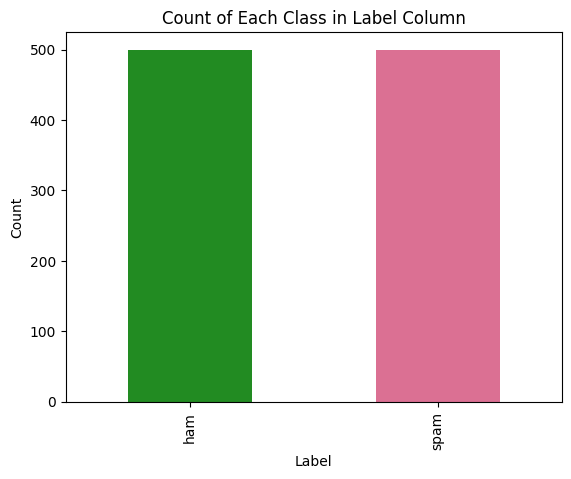

In [8]:
def plot_bar_chart(label_counts):
    label_counts.plot(kind='bar', color=['forestgreen', 'palevioletred'])
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Count of Each Class in Label Column')
    plt.show()

label_counts = df['label'].value_counts()
plot_bar_chart(label_counts)

## Text Data Preprocess

In [9]:
stop_words = set(stopwords_list())

hazm_normalizer = Normalizer()
hazm_stemmer = Stemmer()
hazm_lemmatizer = Lemmatizer()

puncs = [
    '[', '!', '"', '#', '%', '\\', '\"', '(', ')', '*',
    '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '؟', '@', 
    '/', '^', '_', '`', '{', '|', '}', '~',
    '’', '”', '“', '′', '‘', ']','؟','؛','«','»','،','٪'
]

In [10]:
def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

def remove_emails(text):
    return re.sub(r'\S+@\S+', '', text)
    
def remove_phone_numbers(text):
    return re.sub(r'\b\d{8,10,11}\b', '', text)

def remove_repeated_letters(text):
    return re.sub(r'(.)\1+', r'\1', text)

def remove_stop_words(words):
    return [word for word in words if word not in stop_words]




def remove_htmls(text):
    return re.sub(re.compile('<.*?>') , '', text)

def remove_usernames(text):
    return re.sub(r'@[^ ]+', '', text)

def remove_hashtags(text):
    return re.sub(r'#', '', text)

def remove_punctuatoins(text):
    return re.sub(r'[' + re.escape(''.join(puncs)) + r']', ' ', text)

# zwnj : Zero-width non-joiner
def replace_zwnj_with_space(text):
    return text.replace("\u200c", " ")

def normalize_text(text):
    return hazm_normalizer.normalize(text)

def remove_empty_tokens(words):
    return [word for word in words if word.strip() != '']

def stem_words(words):
    return [hazm_stemmer.stem(word) for word in words]

def lemmatize_words(words):
    return [hazm_lemmatizer.lemmatize(word) for word in words]

def join_words_into_string(words):
    return ' '.join(words)

def remove_emojis(text):
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & pictographs
        "\U0001F680-\U0001F6FF"  # Transport & map symbols
        "\U0001F700-\U0001F77F"  # Alchemical symbols
        "\U0001F780-\U0001F7FF"  # Geometric shapes extended
        "\U0001F800-\U0001F8FF"  # Supplemental arrows
        "\U0001F900-\U0001F9FF"  # Supplemental symbols and pictographs
        "\U0001FA00-\U0001FA6F"  # Chess symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and pictographs extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"  # Enclosed characters
        "]+",
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

def remove_bom_characters(text):
    # Remove BOM (Byte Order Mark) or any Zero Width No-Break Space
    return text.replace("\uFEFF", "")


In [11]:
def test_function(func, input_text):
    print(input_text)
    print(func(input_text))

In [12]:
text = """
این برای تست عدد 1 است ببینمی چی میشه
"""
test_function(normalize_text, text)


این برای تست عدد 1 است ببینمی چی میشه


این برای تست عدد ۱ است ببینمی چی میشه



In [13]:
text = """
این برای تست نیم‌فاصله است ببینمی چی میشه
"""
test_function(normalize_text, text)


این برای تست نیم‌فاصله است ببینمی چی میشه


این برای تست نیم‌فاصله است ببینمی چی میشه



In [14]:
text = """
این برای تست نیم‌فاصله است ببینمی چی میشه
"""
test_function(normalize_text, text)


این برای تست نیم‌فاصله است ببینمی چی میشه


این برای تست نیم‌فاصله است ببینمی چی میشه



In [15]:
def preprocess_text(text):
    text = remove_urls(text)
    text = remove_emails(text)
    text = remove_phone_numbers(text)
    text = remove_htmls(text)
    text = remove_usernames(text)
    text = remove_hashtags(text)
    text = replace_zwnj_with_space(text)
    text = remove_repeated_letters(text)
    text = remove_punctuatoins(text)
    text = remove_emojis(text)
    text = remove_bom_characters(text)
    text = normalize_text(text)

    words = word_tokenize(text)
    words = remove_empty_tokens(words)
    words = remove_stop_words(words)
    # words = stem_words(words)
    words = lemmatize_words(words)
    
    text = join_words_into_string(words)
    return text

In [16]:
df['cleaned_text'] = df['text'].apply(preprocess_text)
df.head()

,text,label,cleaned_text
0,﻿ممنون آقا سامان.\nمن پارسال اصلا آزاد شرکت نک...,ham,منون آقا سامان پارسال اصلا آزاد شرکت کرد#کن سر...
1,﻿سلام آقای کریمی\nبالاخره آزمونارشد تموم شد من...,ham,سلام کریمی بالاخره آزمونارشد تموم راحت شد#شو ی...
2,﻿درود بر حاج وحیدی بنده بعنوان یک دکتری تاریخ ...,ham,درود حاج وحید بنده بعنوان دکتری تاریخ دستی تار...
3,﻿با سلام و احترام\nضمن تقدیر از مسولین محترم ...,ham,سلام احترام تقدیر مسولین محترم سایت تابناک رسا...
4,﻿با سلام اینجانب یک دستگاه خودرو پراید 131 با ...,ham,سلام اینجانب دستگاه خودرو پراید ۱۳۱ شماره درخو...


## Feature Extraction (ParseBERT)

In [17]:
model_name = "HooshvareLab/bert-base-parsbert-uncased"

config = AutoConfig.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = TFAutoModel.from_pretrained(model_name)

config.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/963M [00:00<?, ?B/s]

Some layers from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [18]:
max_length = 32
reduced_size = 120  
step = 200

In [19]:
bert_model.config.hidden_size

768

In [20]:
def tokenize_text(text, tokenizer, max_length=32):
    encoding = tokenizer(
        list(text),
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="tf",
    )
    return encoding

In [21]:
text = df['cleaned_text']

tokenized_data = tokenize_text(text, tokenizer)

input_ids = tokenized_data["input_ids"]
attention_mask = tokenized_data["attention_mask"]
token_type_ids = tokenized_data["token_type_ids"]

In [22]:
samples = input_ids.shape[0]
hidden_size = bert_model.config.hidden_size 
device

'/gpu:0'

In [23]:
word_embeddings = np.empty((0, max_length, hidden_size))
iterates = (samples + step - 1) // step
print(f"Total {iterates} steps will be taken.")

Total 5 steps will be taken.


In [24]:
# Process embeddings in batches
for i in range(iterates):
    start = step * i
    end = min(step * (i + 1), samples)
    print(f"Processing batch {i + 1}/{iterates}: {start} to {end}")

    with tf.device(device):
        batch_embeddings = bert_model(
            input_ids=input_ids[start:end],
            attention_mask=attention_mask[start:end],
            token_type_ids=token_type_ids[start:end],
        )[0].numpy()  # Shape: (batch_size, max_length, hidden_size)

        word_embeddings = np.concatenate([word_embeddings, batch_embeddings], axis=0)
    tf.keras.backend.clear_session()

Processing batch 1/5: 0 to 200
Processing batch 2/5: 200 to 400
Processing batch 3/5: 400 to 600
Processing batch 4/5: 600 to 800
Processing batch 5/5: 800 to 1000


## Reduce Dimensions

In [25]:
print(f"Original embeddings shape: {word_embeddings.shape}")

# Reshape to 2D for PCA
word_embeddings_2d = word_embeddings.reshape(-1, hidden_size)

print("Applying PCA to reduce dimensionality...")
pca = PCA(n_components=reduced_size)
reduced_embeddings_2d = pca.fit_transform(word_embeddings_2d)

# Reshape back to 3D (samples, max_length, reduced_size)
reduced_embeddings = reduced_embeddings_2d.reshape(-1, max_length, reduced_size)

print(f"Reduced embeddings shape: {reduced_embeddings.shape}")

Original embeddings shape: (1000, 32, 768)
Applying PCA to reduce dimensionality...
Reduced embeddings shape: (1000, 32, 120)


## Prepare Data for Model

In [26]:
encoder = OneHotEncoder(sparse_output=False)
labels = encoder.fit_transform(df['label'].values.reshape(-1, 1))

In [27]:
word_embeddings = reduced_embeddings
labels = labels[:samples]

In [28]:
def split(x_data, y_data, ratio, seed=42):
    return train_test_split(x_data, y_data, test_size=ratio, random_state=seed)

In [29]:
x_train, x_test, y_train, y_test = split(reduced_embeddings, labels, 0.3)
x_train, x_val, y_train, y_val = split(x_train, y_train, 0.2)

In [30]:
def print_dimensions(x_train, x_test, y_train, y_test, x_val, y_val):
    print(f"Dimensions of the datasets:")
    print(f"x_train: {x_train.shape}")
    print(f"x_test:  {x_test.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_test:  {y_test.shape}")
    print(f"x_val:   {x_val.shape}")
    print(f"y_val:   {y_val.shape}")

print_dimensions(x_train, x_test, y_train, y_test, x_val, y_val)

Dimensions of the datasets:
x_train: (560, 32, 120)
x_test:  (300, 32, 120)
y_train: (560, 2)
y_test:  (300, 2)
x_val:   (140, 32, 120)
y_val:   (140, 2)


## Model Utility Functions

In [31]:
def display_evaluation_metrics(results_df):
    print("\nEvaluation Metrics Table:")
    print(results_df)

    plt.title('ROC Curves')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [32]:
def evaluate_model(model, x_test, y_test, name):
    if hasattr(model, "predict_proba"):
        y_pred = model.predict_proba(x_test)
    else:
        y_pred = model.predict(x_test)
    
    # Get predicted class indices
    y_pred_classes = y_pred.argmax(axis=1)
    y_true_classes = y_test.argmax(axis=1)

    cm = confusion_matrix(y_true_classes, y_pred_classes)

    report = classification_report(y_true_classes, y_pred_classes, output_dict=True, zero_division=0)
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    auc = roc_auc_score(y_test, y_pred, multi_class="ovr")
    fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred.ravel())

    metrics = {
        "Model": name,
        "Accuracy": accuracy,
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-Score": report["weighted avg"]["f1-score"],
        "AUC": auc,
    }

    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
    return metrics, cm

def plot_confusion_matrix(cm, name):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [33]:
def compile_model(model, optimizer, learning_rate):
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model

def build_cnn_lstm(batch_size, learning_rate, optimizer):
    input_layer = Input(shape=(32, 120))
    cnn = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(input_layer)
    cnn = MaxPooling1D(pool_size=2)(cnn)  # Reduces timesteps by half, features stay the same
    lstm = LSTM(64, return_sequences=False, dropout=0.2)(cnn)
    output = Dense(2, activation='softmax')(lstm)

    model = Model(inputs=input_layer, outputs=output)
    return compile_model(model, optimizer, learning_rate)

def build_simple_cnn(batch_size, learning_rate, optimizer):
    input_layer = Input(shape=(32, 120))
    cnn = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(input_layer)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Flatten()(cnn)    
    output = Dense(2, activation='softmax')(cnn)

    model = Model(inputs=input_layer, outputs=output)
    return compile_model(model, optimizer, learning_rate)

def build_simple_lstm(batch_size, learning_rate, optimizer):
    input_layer = Input(shape=(32, 120))
    lstm = LSTM(64, return_sequences=False, dropout=0.2)(input_layer)
    output = Dense(2, activation='softmax')(lstm)

    model = Model(inputs=input_layer, outputs=output)
    return compile_model(model, optimizer, learning_rate)

In [34]:
def train_and_evaluate_model(model, x_train, y_train, x_val, y_val, batch_size, epochs):
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose=0
    )
    val_loss = min(history.history['val_loss'])
    return val_loss

def update_best_model(val_loss, best_val_loss, best_params, best_model, model, batch_size, learning_rate, optimizer):
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'optimizer': optimizer.__name__
        }
        best_model = model
    return best_val_loss, best_params, best_model

def search_best_params_for_model(model_name, model_builder, batch_sizes, learning_rates, optimizers, x_train, y_train, x_val, y_val, epochs):
    best_val_loss = float('inf')
    best_params = None
    best_model = None
    print(f"Training {model_name} with:")
    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            for optimizer in optimizers:
                print(f"batch_size={batch_size}, learning_rate={learning_rate}, optimizer={optimizer.__name__}")
                model = model_builder(batch_size, learning_rate, optimizer)
                val_loss = train_and_evaluate_model(model, x_train, y_train, x_val, y_val, batch_size, epochs)
                best_val_loss, best_params, best_model = update_best_model(
                    val_loss, best_val_loss, best_params, best_model, model, batch_size, learning_rate, optimizer
                )
                del model
                clear_session()
                gc.collect()

    return best_val_loss, best_params, best_model

## Greedy Search Algorithm for CNN-LSTM

In [35]:
models = {
    'CNN-LSTM': build_cnn_lstm,
    'Simple-CNN': build_simple_cnn,
    'Simple-LSTM': build_simple_lstm
}

# batch_sizes = [8, 16, 32, 64]
# learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [8, 64]
learning_rates = [0.001, 0.0001]
optimizers = [Adam, SGD]

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

In [36]:
all_best_params = {}
best_models = {}

for model_name, model_builder in models.items():
    print(f"Searching best parameters for {model_name}...")
    best_val_loss, best_params, best_model = search_best_params_for_model(
        model_name=model_name,
        model_builder=model_builder,
        batch_sizes=batch_sizes,
        learning_rates=learning_rates,
        optimizers=optimizers,
        x_train=x_train,
        y_train=y_train,
        x_val=x_val,
        y_val=y_val,
        epochs=50
    )
    all_best_params[model_name] = {
        'best_params': best_params,
        'best_val_loss': best_val_loss
    }
    best_models[model_name] = best_model
        
    print(f"Best Validation Loss: {best_val_loss}")
    print(f"Best Parameters: {best_params}")
    print("-----------")

Searching best parameters for CNN-LSTM...
Training CNN-LSTM with:
batch_size=8, learning_rate=0.001, optimizer=Adam
batch_size=8, learning_rate=0.001, optimizer=SGD
batch_size=8, learning_rate=0.0001, optimizer=Adam
batch_size=8, learning_rate=0.0001, optimizer=SGD
batch_size=64, learning_rate=0.001, optimizer=Adam
batch_size=64, learning_rate=0.001, optimizer=SGD
batch_size=64, learning_rate=0.0001, optimizer=Adam
batch_size=64, learning_rate=0.0001, optimizer=SGD
Best Validation Loss: 0.1741296797990799
Best Parameters: {'batch_size': 8, 'learning_rate': 0.0001, 'optimizer': 'Adam'}
-----------
Searching best parameters for Simple-CNN...
Training Simple-CNN with:
batch_size=8, learning_rate=0.001, optimizer=Adam


I0000 00:00:1734891371.242204     113 service.cc:145] XLA service 0x5cdd078610d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734891371.242254     113 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1734891371.855184     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


batch_size=8, learning_rate=0.001, optimizer=SGD
batch_size=8, learning_rate=0.0001, optimizer=Adam
batch_size=8, learning_rate=0.0001, optimizer=SGD
batch_size=64, learning_rate=0.001, optimizer=Adam
batch_size=64, learning_rate=0.001, optimizer=SGD
batch_size=64, learning_rate=0.0001, optimizer=Adam
batch_size=64, learning_rate=0.0001, optimizer=SGD
Best Validation Loss: 0.17316123843193054
Best Parameters: {'batch_size': 8, 'learning_rate': 0.001, 'optimizer': 'Adam'}
-----------
Searching best parameters for Simple-LSTM...
Training Simple-LSTM with:
batch_size=8, learning_rate=0.001, optimizer=Adam
batch_size=8, learning_rate=0.001, optimizer=SGD
batch_size=8, learning_rate=0.0001, optimizer=Adam
batch_size=8, learning_rate=0.0001, optimizer=SGD
batch_size=64, learning_rate=0.001, optimizer=Adam
batch_size=64, learning_rate=0.001, optimizer=SGD
batch_size=64, learning_rate=0.0001, optimizer=Adam
batch_size=64, learning_rate=0.0001, optimizer=SGD
Best Validation Loss: 0.175390183925

## Plot Metrics

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Evaluation Metrics Table:
         Model  Accuracy  Precision    Recall  F1-Score       AUC
0     CNN-LSTM  0.940000   0.940078  0.940000  0.939997  0.976089
1   Simple-CNN  0.936667   0.936686  0.936667  0.936666  0.984400
2  Simple-LSTM  0.913333   0.913996  0.913333  0.913299  0.963778


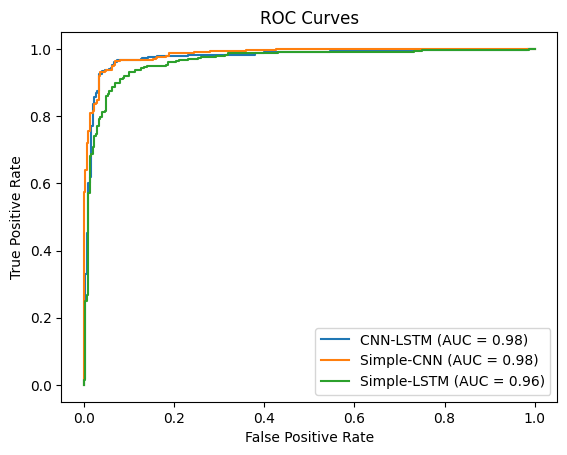

In [37]:
metrics_list = []
model_cms = []
for name, model in best_models.items():
    metrics, cm = evaluate_model(model, x_test, y_test, name)
    metrics_list.append(metrics)
    model_cms.append(cm)

results_df = pd.DataFrame(metrics_list)
display_evaluation_metrics(results_df)

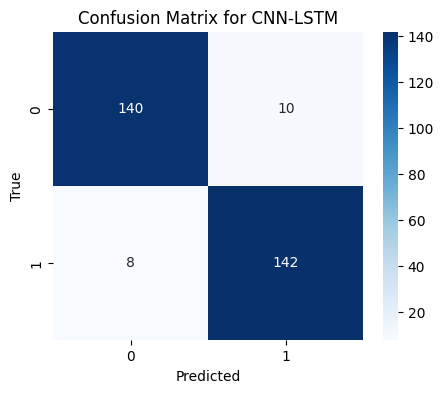

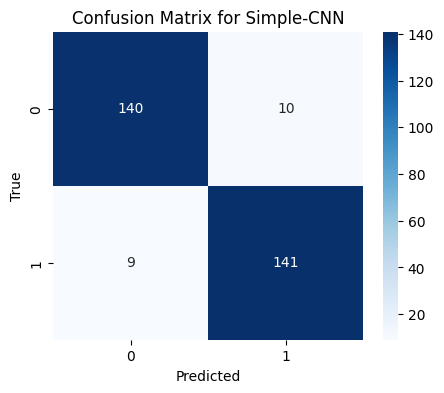

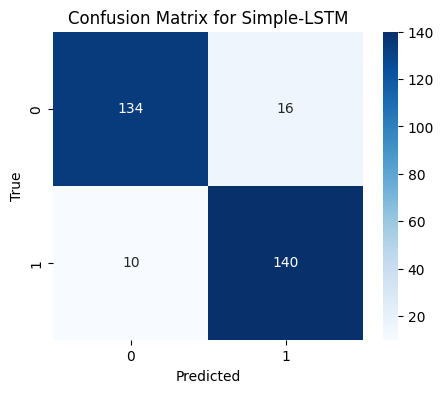

In [38]:
for index, (name, model) in enumerate(best_models.items()):
    plot_confusion_matrix(model_cms[index], name)


## Feature Extraction (Bag of Words)

In [39]:
vectorizer = CountVectorizer(max_features=120) 
X_BoW = vectorizer.fit_transform(df['cleaned_text']).toarray()
X_train_BoW, X_test_BoW, y_train_BoW, y_test_BoW = split(X_BoW, labels, ratio=0.3)

## Train on Traditional Models

In [40]:
traditional_models = {
    "Support Vector Machine": SVC(probability=True, kernel="linear", random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42),
    "Bagging Classifier": BaggingClassifier(n_estimators=50, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=50, random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Multinomial Naive Bayes": MultinomialNB(),
}



Evaluation Metrics Table:
                     Model  Accuracy  Precision    Recall  F1-Score       AUC
0   Support Vector Machine  0.920000   0.921198  0.920000  0.919943  0.972933
1                 AdaBoost  0.920000   0.920075  0.920000  0.919996  0.965800
2       Bagging Classifier  0.930000   0.930938  0.930000  0.929962  0.964489
3              Extra Trees  0.950000   0.950180  0.950000  0.949995  0.980889
4      Logistic Regression  0.936667   0.936686  0.936667  0.936666  0.982756
5            Random Forest  0.926667   0.926970  0.926667  0.926654  0.985111
6  Multinomial Naive Bayes  0.913333   0.914512  0.913333  0.913272  0.976467


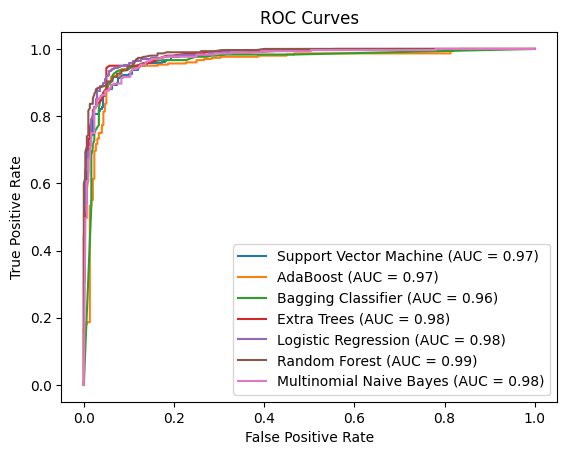

In [41]:
traditional_metrics = []
model_cms = []

for name, model in traditional_models.items():
    model.fit(X_train_BoW, y_train_BoW.argmax(axis=1))
    metrics, cm = evaluate_model(model, X_test_BoW, y_test_BoW, name)
    traditional_metrics.append(metrics)
    model_cms.append(cm)

traditional_results_df = pd.DataFrame(traditional_metrics)
display_evaluation_metrics(traditional_results_df)

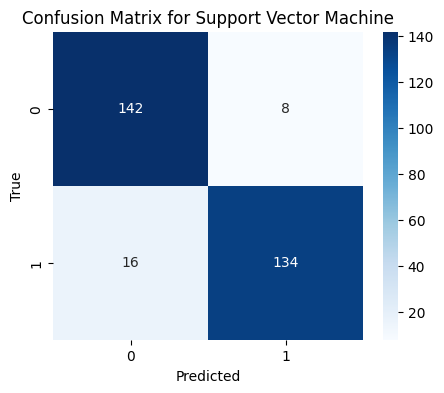

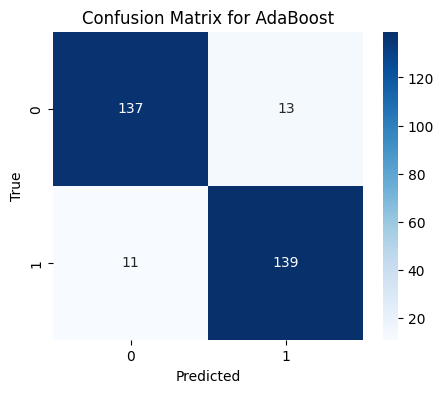

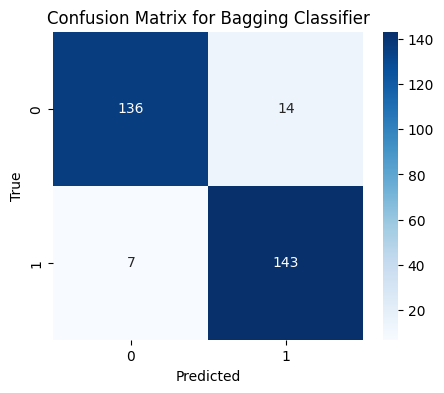

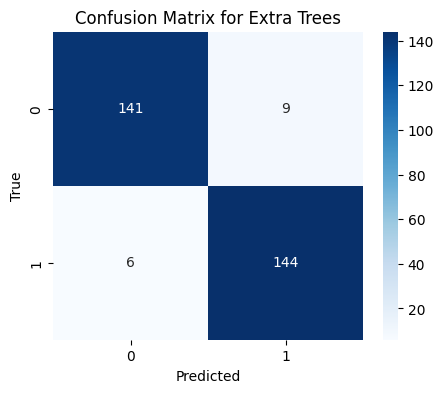

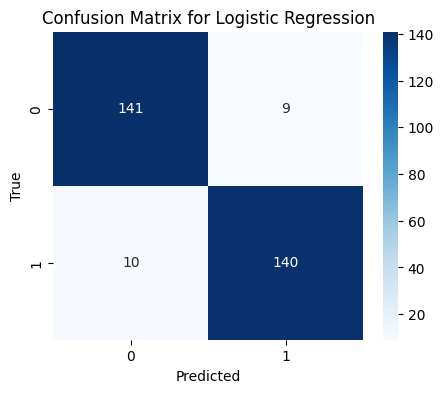

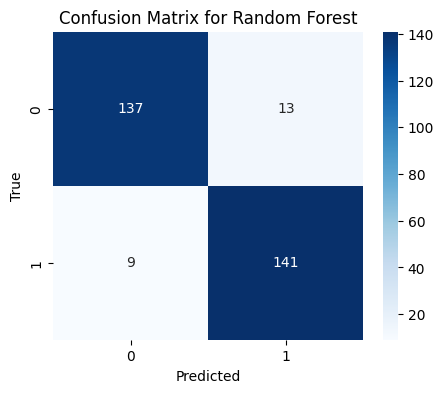

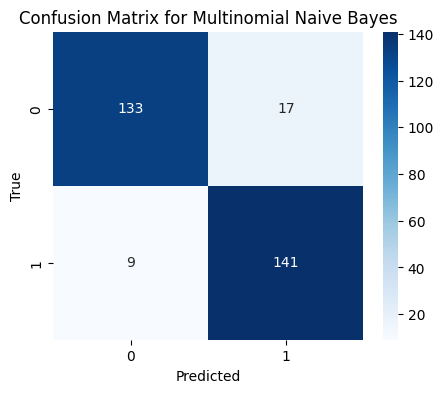

In [42]:
for index, (name, model) in enumerate(traditional_models.items()):
    plot_confusion_matrix(model_cms[index], name)


In [43]:
combined_results_df = pd.concat([results_df, traditional_results_df], ignore_index=True)
classifiers = [
    "Support Vector Machine", "AdaBoost", "Bagging Classifier", "Extra Trees",
    "Logistic Regression", "Random Forest", "Multinomial Naive Bayes",
    "CNN-LSTM", "Simple-CNN", "Simple-LSTM"
]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']

data = []
for classifier in classifiers:
    classifier_metrics = combined_results_df[combined_results_df['Model'] == classifier][metrics].values.flatten().tolist()
    data.append(classifier_metrics)
data = np.array(data)

In [44]:
combined_results_df = pd.concat([results_df, traditional_results_df], ignore_index=True)

def highlight_max(s): 
    is_max = s == s.max() 
    return ['font-weight: bold' if v else '' for v in is_max] 

styled_df = combined_results_df.style.apply(highlight_max, subset=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'])
styled_df

,Model,Accuracy,Precision,Recall,F1-Score,AUC
0,CNN-LSTM,0.940000,0.940078,0.940000,0.939997,0.976089
1,Simple-CNN,0.936667,0.936686,0.936667,0.936666,0.984400
2,Simple-LSTM,0.913333,0.913996,0.913333,0.913299,0.963778
3,Support Vector Machine,0.920000,0.921198,0.920000,0.919943,0.972933
4,AdaBoost,0.920000,0.920075,0.920000,0.919996,0.965800
5,Bagging Classifier,0.930000,0.930938,0.930000,0.929962,0.964489
6,Extra Trees,0.950000,0.950180,0.950000,0.949995,0.980889
7,Logistic Regression,0.936667,0.936686,0.936667,0.936666,0.982756
8,Random Forest,0.926667,0.926970,0.926667,0.926654,0.985111
9,Multinomial Naive Bayes,0.913333,0.914512,0.913333,0.913272,0.976467


In [45]:
def highlight_max(s): 
    is_max = s == s.max() 
    return ['font-weight: bold' if v else '' for v in is_max] 

def plot_classification_metrics(metrics, classifiers, data):
    x = np.arange(len(metrics))
    width = 0.07

    fig, ax = plt.subplots(figsize=(12, 6))

    for i in range(len(classifiers)):
        ax.bar(x + i*width, data[i], width, label=classifiers[i])

    ax.set_xlabel('Classification evaluation measures')
    ax.set_ylabel('Scores')
    ax.set_title('Classification Evaluation Metrics')
    ax.set_xticks(x + width * (len(classifiers) - 1) / 2)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_xticklabels(metrics)
    ax.legend(loc='best', fontsize='small')

    plt.show()
    

styled_df = combined_results_df.style.apply(highlight_max, subset=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'])
styled_df

,Model,Accuracy,Precision,Recall,F1-Score,AUC
0,CNN-LSTM,0.940000,0.940078,0.940000,0.939997,0.976089
1,Simple-CNN,0.936667,0.936686,0.936667,0.936666,0.984400
2,Simple-LSTM,0.913333,0.913996,0.913333,0.913299,0.963778
3,Support Vector Machine,0.920000,0.921198,0.920000,0.919943,0.972933
4,AdaBoost,0.920000,0.920075,0.920000,0.919996,0.965800
5,Bagging Classifier,0.930000,0.930938,0.930000,0.929962,0.964489
6,Extra Trees,0.950000,0.950180,0.950000,0.949995,0.980889
7,Logistic Regression,0.936667,0.936686,0.936667,0.936666,0.982756
8,Random Forest,0.926667,0.926970,0.926667,0.926654,0.985111
9,Multinomial Naive Bayes,0.913333,0.914512,0.913333,0.913272,0.976467


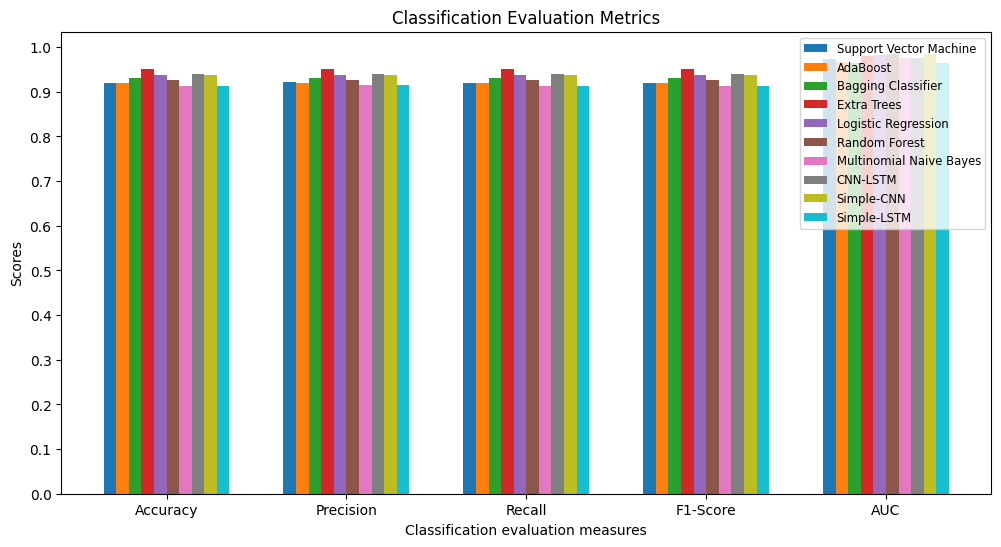

In [46]:
plot_classification_metrics(metrics, classifiers, data)

In [47]:
print(combined_results_df)

                     Model  Accuracy  Precision    Recall  F1-Score       AUC
0                 CNN-LSTM  0.940000   0.940078  0.940000  0.939997  0.976089
1               Simple-CNN  0.936667   0.936686  0.936667  0.936666  0.984400
2              Simple-LSTM  0.913333   0.913996  0.913333  0.913299  0.963778
3   Support Vector Machine  0.920000   0.921198  0.920000  0.919943  0.972933
4                 AdaBoost  0.920000   0.920075  0.920000  0.919996  0.965800
5       Bagging Classifier  0.930000   0.930938  0.930000  0.929962  0.964489
6              Extra Trees  0.950000   0.950180  0.950000  0.949995  0.980889
7      Logistic Regression  0.936667   0.936686  0.936667  0.936666  0.982756
8            Random Forest  0.926667   0.926970  0.926667  0.926654  0.985111
9  Multinomial Naive Bayes  0.913333   0.914512  0.913333  0.913272  0.976467
